In [1]:
# we use pandas for data preprocessing
import pandas as pd
import numpy as np


# plot data
import matplotlib.pyplot as plt
import seaborn as sns

# we need split API from sklearn to split the data set into train/test
from sklearn.model_selection import train_test_split

# we need to Load libraries and use Tree model
from sklearn.tree import DecisionTreeClassifier

# we also need scikit-learn metrics module for accuracy calculation
from sklearn import metrics        

In [2]:
# load in the transfer fee data into dataframe
# file_path = C:\Users\tycho\Downloads
df = pd.read_csv(r'final_data.csv')
transfer = df[['current_value', 'height', 'age', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'games_injured', 'award']]
# first 5 rows
# display(transfer.head())

# print("Dataset shape: ",transfer.shape)
# print("\nData Types:\n", transfer.dtypes)
# missing_values = transfer.isnull().sum()
# print("\nMissing values:\n", missing_values)
print("\nDescriptive Statistics:\n", transfer.describe())


Descriptive Statistics:
        current_value        height           age         goals       assists  \
count   1.075400e+04  10754.000000  10754.000000  10754.000000  10754.000000   
mean    3.622971e+06    181.240353     26.041903      0.125554      0.086978   
std     9.095410e+06      6.969818      4.777629      0.235585      0.143351   
min     0.000000e+00    156.000000     15.000000      0.000000      0.000000   
25%     3.000000e+05    176.000000     22.000000      0.000000      0.000000   
50%     8.000000e+05    181.240353     26.000000      0.045969      0.040773   
75%     3.000000e+06    186.000000     29.000000      0.172263      0.133136   
max     1.800000e+08    206.000000     43.000000     11.250000      4.000000   

       yellow cards  second yellow cards     red cards  goals conceded  \
count  10754.000000         10754.000000  10754.000000    10754.000000   
mean       0.189757             0.004666      0.006826        0.131655   
std        0.432388            

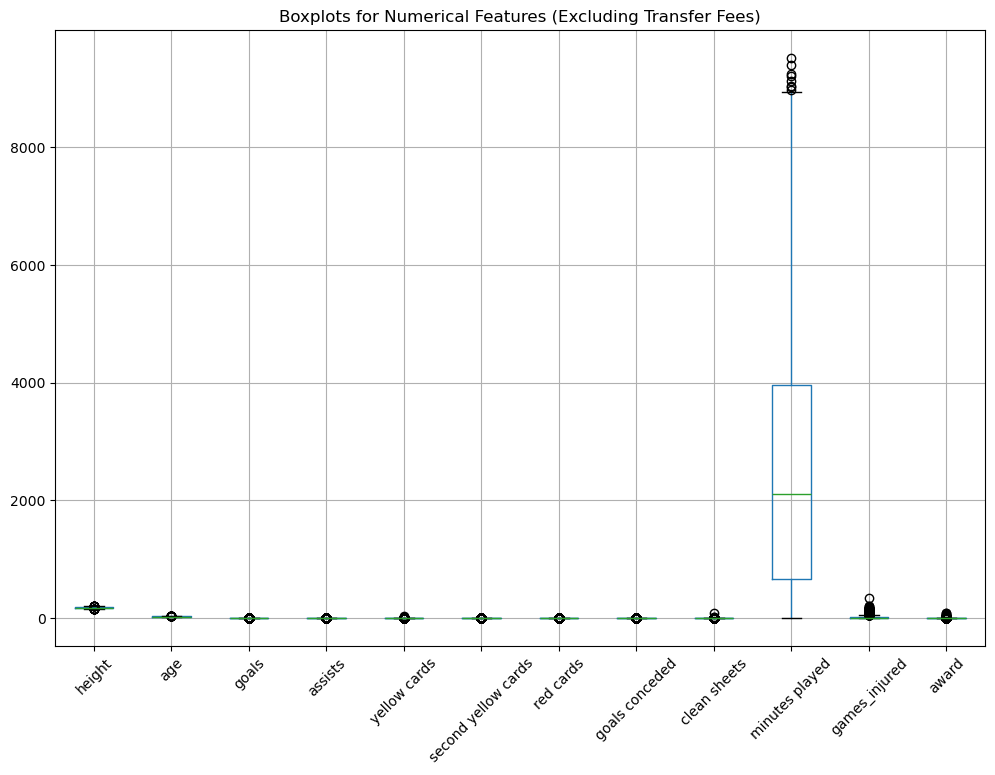

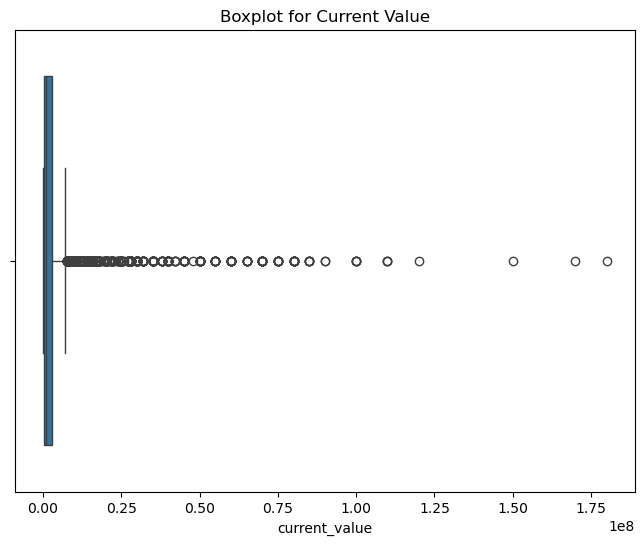

In [3]:
transfer_fee_columns = ['current_value']
other_columns = ['height', 'age', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'games_injured', 'award']

# Boxplots for other columns
plt.figure(figsize=(12, 8))
transfer[other_columns].boxplot()
plt.title("Boxplots for Numerical Features (Excluding Transfer Fees)")
plt.xticks(rotation=45)
plt.show()

# Boxplot for current_value
plt.figure(figsize=(8, 6))
sns.boxplot(data=transfer, x='current_value')
plt.title("Boxplot for Current Value")
plt.show()


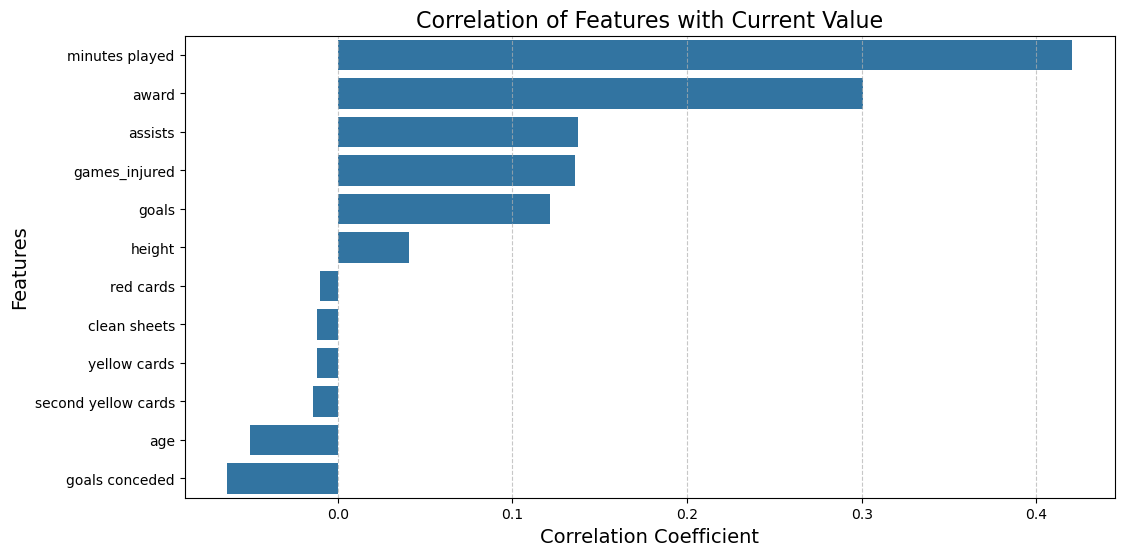

In [4]:
# Compute correlations with the target variable
correlations = transfer.corr()['current_value'].sort_values(ascending=False)

# Drop the correlation of the target variable with itself (1.0)
correlations = correlations.drop('current_value')

# Plot the correlations as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)

# Add labels and title
plt.title('Correlation of Features with Current Value', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Display gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()



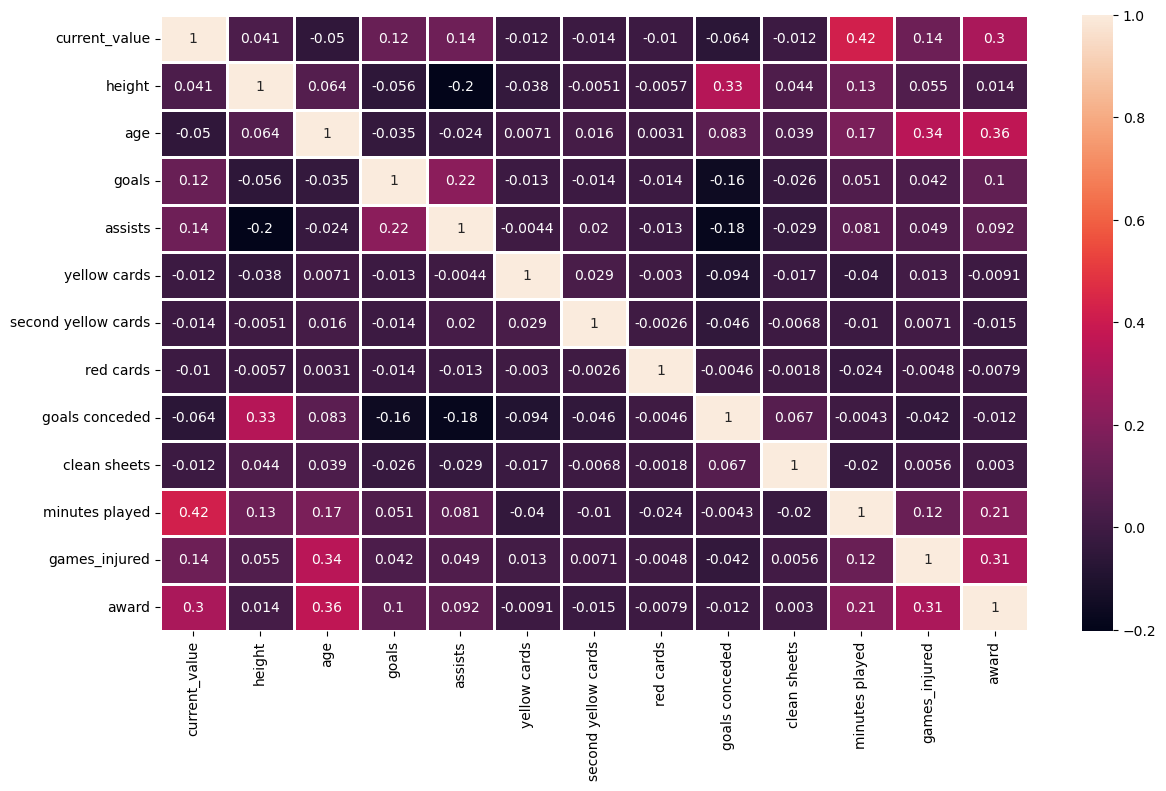

In [5]:
# use a bigger size
plt.figure(figsize=(14, 8))

# correlation heatmap
sns.heatmap(transfer.corr(), annot=True, linewidth =1)

plt.show() 

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

X = transfer[other_columns]
y = transfer['current_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)


cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [ 0.08674445  0.31556848 -3.06623191 -0.85342799 -7.27058497]


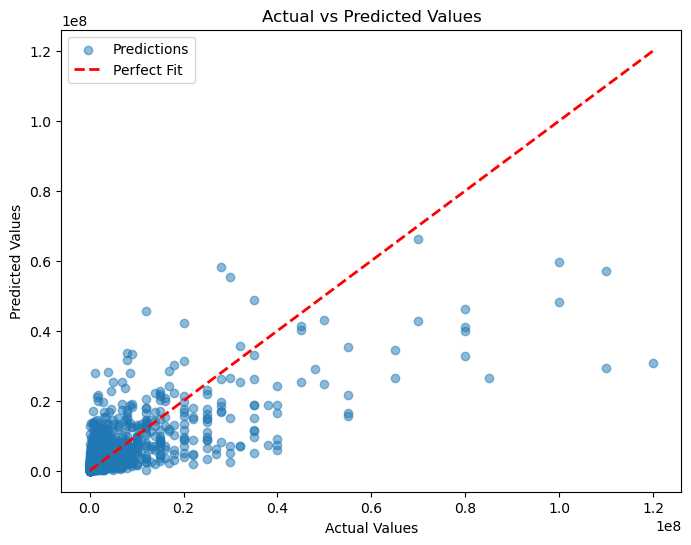

In [7]:
# Predictions from Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Scatter plot for actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],       
    'max_depth': [None, 10, 20],          
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4]         
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,                
    cv=3,                     
    n_jobs=-1,                
    verbose=2,               
    random_state=42           
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.48837055446898847


In [9]:
## Since the optimized Random forest regressor has the best CV score of 0.48,
## we should look if we can optimize it more by looking at the data

transfer_modified = transfer.copy()

# method to cap outliers
def cap_outliers(df, columns):
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)
    return df

columns_to_cap = ['current_value'] + other_columns
transfer_modified = cap_outliers(transfer_modified, columns_to_cap)


X_modified = transfer_modified[other_columns]
y_modified = transfer_modified['current_value']


X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(X_modified, y_modified, test_size=0.2, random_state=42)


param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)


random_search.fit(X_train_modified, y_train_modified)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.4952505237511546


with capped outliers and current_value_log (deleted since performed worse):
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.39082743019897287

with capped outliers and current_value:
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.4952505237511546

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

best_rf_model = random_search.best_estimator_

y_pred_test = best_rf_model.predict(X_test_modified)

rmse = np.sqrt(mean_squared_error(y_test_modified, y_pred_test))
r2 = r2_score(y_test_modified, y_pred_test)

print(f"Test Set RMSE: {rmse}")
print(f"Test Set R-squared: {r2}")


Test Set RMSE: 4815892.064515973
Test Set R-squared: 0.5561897823200554


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_d

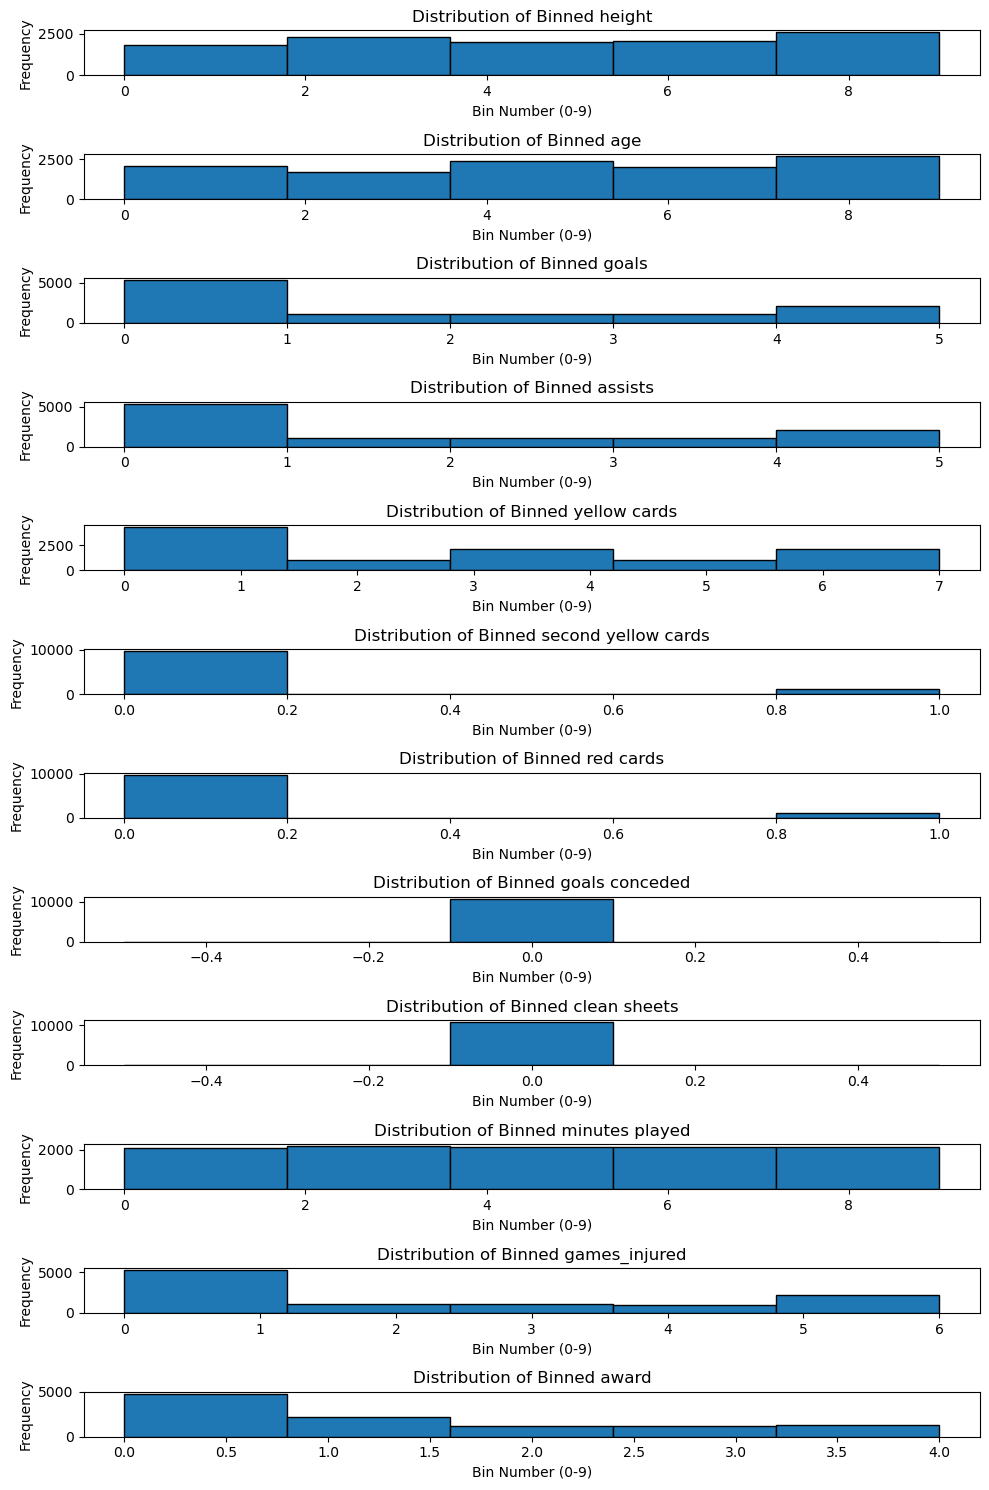

In [12]:
from sklearn.preprocessing import KBinsDiscretizer


features_to_bin = transfer_modified[other_columns]

# initialize binner to bin dataset
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binned_features = binner.fit_transform(features_to_bin)

# Plot the distribution of binned values for each feature
fig, axes = plt.subplots(len(other_columns), 1, figsize=(10, 15))
for idx, col in enumerate(other_columns):
    axes[idx].hist(binned_features[:, idx], bins=5, edgecolor='black')
    axes[idx].set_title(f'Distribution of Binned {col}')
    axes[idx].set_xlabel(f'Bin Number (0-9)')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
transfer_modified['player'] = df['player']  
df_position = df[['player', 'position_encoded']]

# Now merge
transfer_modified = transfer_modified.merge(df_position, on='player', how='left')

# bin the sparse features into two categories
transfer_modified['second_yellow_binned'] = transfer_modified['second yellow cards'].apply(lambda x: 1 if x > 0 else 0)
transfer_modified['red_card_binned'] = transfer_modified['red cards'].apply(lambda x: 1 if x > 0 else 0)

# for goalkeepers, create bins for goals conceded and clean sheets, otherwise handle as continuous for others
transfer_modified['goals_conceded_binned'] = transfer_modified.apply(lambda row: 1 if row['position_encoded'] == 1 and row['goals conceded'] > 0 else 0, axis=1)
transfer_modified['clean_sheets_binned'] = transfer_modified.apply(lambda row: 1 if row['position_encoded'] == 1 and row['clean sheets'] > 0 else 0, axis=1)


In [14]:
# Handle goalkeeper-specific metrics
goalkeeper_features = ['goals conceded', 'clean sheets']

# Remove non-goalkeepers' values for these metrics
for col in goalkeeper_features:
    transfer_modified.loc[transfer_modified['position_encoded'] != 1, col] = 0

In [15]:
X = transfer_modified.drop(columns=['current_value', 'player', 'goals conceded', 'clean sheets'] + goalkeeper_features)

y = transfer_modified['current_value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest with hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.4949317794528138


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 2446734.202480237
Mean Squared Error (MSE): 23131563968266.348
Root Mean Squared Error (RMSE): 4809528.455916063
R² Score: 0.5573618885637166


Not binned:
Mean Absolute Error (MAE): 2444658.567769861
Mean Squared Error (MSE): 23192816377067.92
Root Mean Squared Error (RMSE): 4815892.064515973
R² Score: 0.5561897823200554

binned independent variables:
Mean Absolute Error (MAE): 2447075.637155298
Mean Squared Error (MSE): 23146538840406.113
Root Mean Squared Error (RMSE): 4811084.996173536
R² Score: 0.5570753342636252

                  Feature  Importance
7          minutes played    0.367997
1                     age    0.160968
9                   award    0.144111
8           games_injured    0.091220
2                   goals    0.075037
3                 assists    0.058318
4            yellow cards    0.048669
0                  height    0.032755
6               red cards    0.006446
5     second yellow cards    0.006417
10       position_encoded    0.005895
11   second_yellow_binned    0.001061
12        red_card_binned    0.000619
14    clean_sheets_binned    0.000368
13  goals_conceded_binned    0.000120


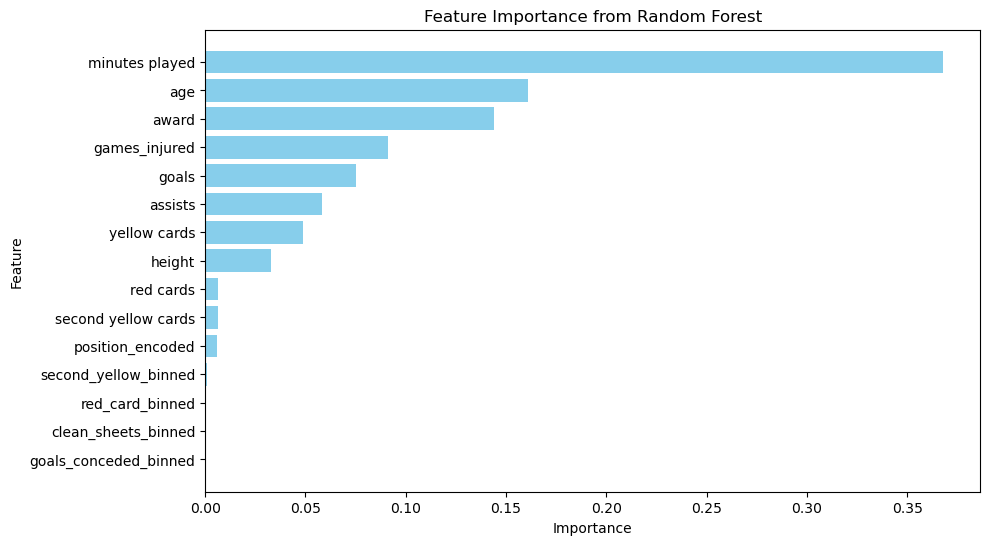

In [18]:
# Get feature importance from the best random forest model
feature_importances = best_rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot 
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [19]:
## binning the target variable to improve model

bins = 10 
transfer_modified['current_value_bin'] = pd.qcut(transfer_modified['current_value'], bins, labels=False)

# balance data set
balanced_data = transfer_modified.groupby('current_value_bin', group_keys=False).apply(
    lambda x: x.sample(n=transfer_modified['current_value_bin'].value_counts().min(), random_state=42)
)


# Remove target, player, and other unnecessary columns in both train and test data
X_balanced = balanced_data.drop(columns=['current_value', 'current_value_bin', 'player'])
X_balanced = X_balanced.drop(columns=['goals conceded', 'clean sheets']) 

y_balanced = balanced_data['current_value']


X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=balanced_data['current_value_bin']
)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit model
random_search.fit(X_train_balanced, y_train_balanced)

# Output
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/var/folders/l0/8q488tkj79190x0hfqn7ddq40000gn/T/ipykernel_7661/4097181581.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = transfer_modified.groupby('current_value_bin', group_keys=False).apply(


Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.5098207167400638


In [20]:
# Predict using the best model
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test_balanced)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_balanced, y_pred)
mse = mean_squared_error(y_test_balanced, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_balanced, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 2591112.4375398634
Mean Squared Error (MSE): 27464386241704.38
Root Mean Squared Error (RMSE): 5240647.502141733
R² Score: 0.5163471331238721


                  Feature  Importance
7          minutes played    0.356903
1                     age    0.172159
9                   award    0.150943
8           games_injured    0.094684
2                   goals    0.065348
3                 assists    0.060240
4            yellow cards    0.048148
0                  height    0.030873
10       position_encoded    0.007633
5     second yellow cards    0.006229
6               red cards    0.004557
12        red_card_binned    0.001207
11   second_yellow_binned    0.000741
13  goals_conceded_binned    0.000257
14    clean_sheets_binned    0.000078


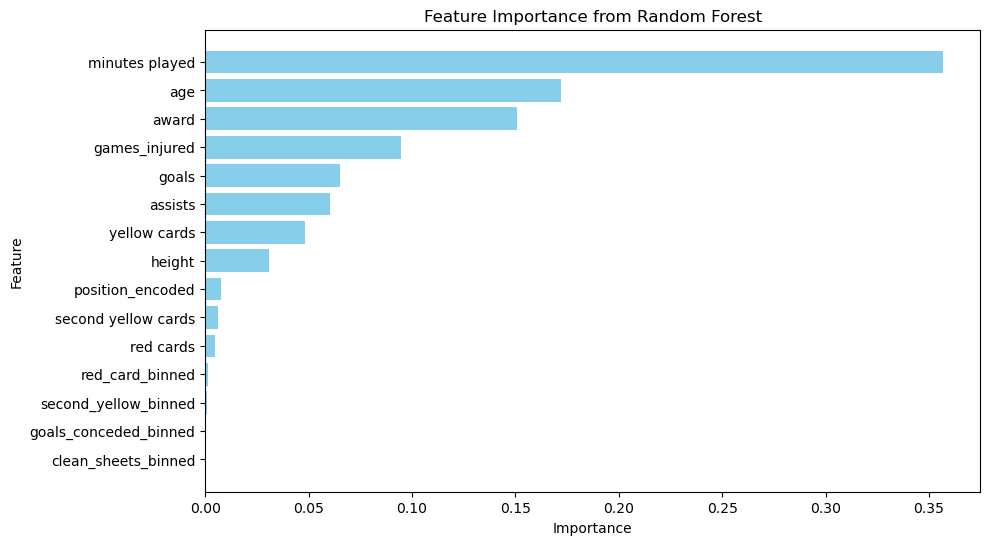

In [21]:
# Get feature importance from the best random forest model
feature_importances = best_rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [22]:
# Select the specified features
selected_features = ['minutes played', 'age', 'award', 'games_injured', 'goals', 'assists', 'yellow cards', 'height']
X_selected = transfer_modified[selected_features]
y_selected = transfer_modified['current_value']

# Train-test split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

# Random Forest with hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_selected = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
random_search_selected.fit(X_train_selected, y_train_selected)

# Output best parameters and cross-validation score
print("Best parameters:", random_search_selected.best_params_)
print("Best CV score:", random_search_selected.best_score_)

# Best model
best_rf_model_selected = random_search_selected.best_estimator_

# Make predictions
y_pred_selected = best_rf_model_selected.predict(X_test_selected)

# Calculate evaluation metrics
mae_selected = mean_absolute_error(y_test_selected, y_pred_selected)
mse_selected = mean_squared_error(y_test_selected, y_pred_selected)
rmse_selected = np.sqrt(mse_selected)
r2_selected = r2_score(y_test_selected, y_pred_selected)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae_selected}")
print(f"Mean Squared Error (MSE): {mse_selected}")
print(f"Root Mean Squared Error (RMSE): {rmse_selected}")
print(f"R² Score: {r2_selected}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score: 0.4963020621896619
Mean Absolute Error (MAE): 2491474.5100237816
Mean Squared Error (MSE): 23666540835922.69
Root Mean Squared Error (RMSE): 4864826.907087516
R² Score: 0.5471247446037852


After binning of features, binning of target variable, log transformation and feature selection, no big improvement was made in terms of the metric scores so now trying to see if a different model might perform better.

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter grid for tuning
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1, 10]
}


xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,  
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


random_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# Make predictions and evaluate
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost - Mean Absolute Error (MAE): {mae}")
print(f"XGBoost - Mean Squared Error (MSE): {mse}")
print(f"XGBoost - Root Mean Squared Error (RMSE): {rmse}")
print(f"XGBoost - R² Score: {r2}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV score: 0.50165985689283
XGBoost - Mean Absolute Error (MAE): 2402114.013566546
XGBoost - Mean Squared Error (MSE): 22673863451003.83
XGBoost - Root Mean Squared Error (RMSE): 4761708.0392443035
XGBoost - R² Score: 0.5661202973268433


Best K: 17
Best Metric: manhattan
Best CV Score (MSE): 28247644835053.344
KNN - Mean Absolute Error (MAE): 2487493.915278803
KNN - Mean Squared Error (MSE): 25507101863139.22
KNN - Root Mean Squared Error (RMSE): 5050455.60946131
KNN - R² Score: 0.5119043652905655


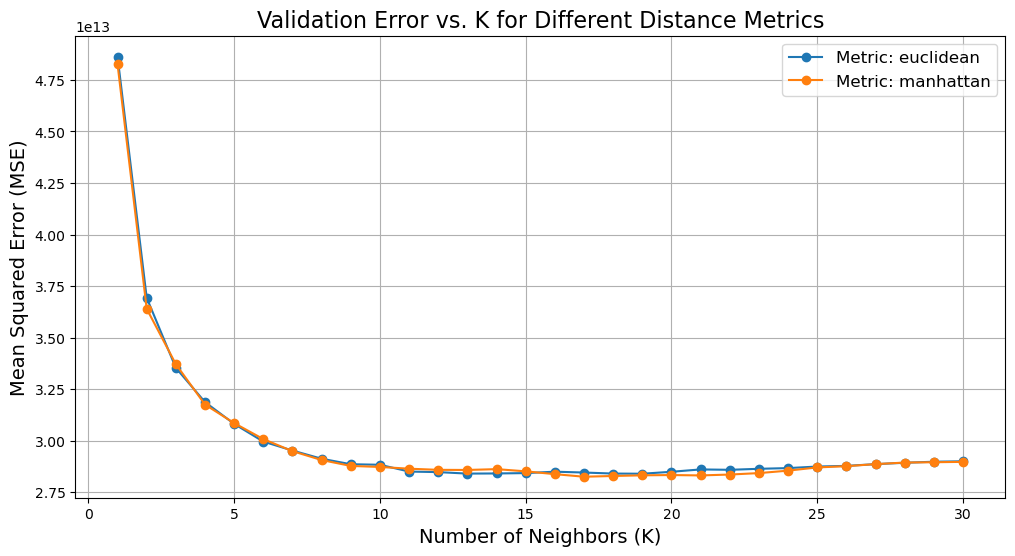

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Select the specified features
selected_features = ['minutes played', 'age', 'award', 'games_injured', 'goals', 'assists', 'yellow cards', 'height']
X_selected = transfer_modified[selected_features]
y_selected = transfer_modified['current_value']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# K values to test
param_grid = {'n_neighbors': range(1, 31), 'metric': ['euclidean', 'manhattan']}


knn = KNeighborsRegressor()

# GridSearchCV to find the best K
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Output the best K and metric
best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_cv_score = -grid_search.best_score_ 
print(f"Best K: {best_k}")
print(f"Best Metric: {best_metric}")
print(f"Best CV Score (MSE): {best_cv_score}")

# Train and predict best model
best_knn = grid_search.best_estimator_


y_pred = best_knn.predict(X_test_scaled)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"KNN - Mean Absolute Error (MAE): {mae}")
print(f"KNN - Mean Squared Error (MSE): {mse}")
print(f"KNN - Root Mean Squared Error (RMSE): {rmse}")
print(f"KNN - R² Score: {r2}")

# Plot validation errors vs K for both Manhattan and Euclidean distance metric
plt.figure(figsize=(12, 6))

# Extract results for each metric
results = grid_search.cv_results_
k_values = range(1, 31)

for metric in ['euclidean', 'manhattan']:
    mean_errors = []
    for k in k_values:
        
        indices = (results['param_metric'] == metric) & (results['param_n_neighbors'] == k)
        mean_cv_error = -np.mean(results['mean_test_score'][indices])  
        mean_errors.append(mean_cv_error)

    # Plot the validation errors
    plt.plot(k_values, mean_errors, label=f'Metric: {metric}', marker='o')

# Customize the plot
plt.title('Validation Error vs. K for Different Distance Metrics', fontsize=16)
plt.xlabel('Number of Neighbors (K)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [31]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=5)  # adjustable
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

grid_search_pca = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train)

best_k_pca = grid_search_pca.best_params_['n_neighbors']
best_metric_pca = grid_search_pca.best_params_['metric']
best_cv_score_pca = -grid_search_pca.best_score_
print(f"Best K with PCA: {best_k_pca}")
print(f"Best Metric with PCA: {best_metric_pca}")
print(f"Best CV Score (MSE) with PCA: {best_cv_score_pca}")

best_knn_pca = grid_search_pca.best_estimator_
y_pred_pca = best_knn_pca.predict(X_test_pca)

mae_pca = mean_absolute_error(y_test, y_pred_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
rmse_pca = np.sqrt(mse_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print(f"KNN with PCA - Mean Absolute Error (MAE): {mae_pca}")
print(f"KNN with PCA - Mean Squared Error (MSE): {mse_pca}")
print(f"KNN with PCA - Root Mean Squared Error (RMSE): {rmse_pca}")
print(f"KNN with PCA - R² Score: {r2_pca}")


Best K with PCA: 28
Best Metric with PCA: euclidean
Best CV Score (MSE) with PCA: 34596101772344.863
KNN with PCA - Mean Absolute Error (MAE): 2996488.6763631534
KNN with PCA - Mean Squared Error (MSE): 33413163200819.027
KNN with PCA - Root Mean Squared Error (RMSE): 5780412.026907686
KNN with PCA - R² Score: 0.3606165377917019


K-NN model performed best when no PCA was applied, manhattan metric performed slightly better than euclidean metric

In [33]:
from sklearn.ensemble import VotingRegressor

# ensemble Random Forest Regressor, XGBoost, and K-nearest Neighbor
knn = KNeighborsRegressor(n_neighbors=17, metric='manhattan')  # Using the best K and metric from earlier
rfr = RandomForestRegressor(
    n_estimators=50, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    max_depth=None, 
    random_state=42
) 
xg_regressor = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.05, 
    max_depth=6, 
    min_child_weight=10, 
    subsample=0.8, 
    colsample_bytree=0.8,
    gamma=0.3,
    random_state=42
)

# ensemble with VotingRegressor
ensemble_model = VotingRegressor(estimators=[('knn', knn), ('rfr', rfr), ('xgboost', xg_regressor)])


ensemble_model.fit(X_train_scaled, y_train)


y_pred = ensemble_model.predict(X_test_scaled)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"Ensemble - Mean Absolute Error (MAE): {mae}")
print(f"Ensemble - Mean Squared Error (MSE): {mse}")
print(f"Ensemble - Root Mean Squared Error (RMSE): {rmse}")
print(f"Ensemble - R² Score: {r2}")


Ensemble - Mean Absolute Error (MAE): 2404656.801141812
Ensemble - Mean Squared Error (MSE): 22693092226722.69
Ensemble - Root Mean Squared Error (RMSE): 4763726.716208927
Ensemble - R² Score: 0.5657523417065011


In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [39]:
# Initialize the MLPRegressor model
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=1000, random_state=42)
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=5000, random_state=42) #45955923847049.41
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='lbfgs', max_iter=3000, random_state=42) #171947237566026.78
#ann_model = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=4000, random_state=42) #45955923847049.41
#ann_model = MLPRegressor(hidden_layer_sizes=(200, 100, 100), activation='relu', solver='adam', max_iter=4000, random_state=42) #44069801944013.69
ann_model = MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', max_iter=4000, random_state=42) #44069801944013.69

In [41]:
ann_model.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(200, 100), max_iter=4000, random_state=42)

In [42]:
y_pred_ann = ann_model.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming y_test and y_pred_ann are defined
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
mse_ann = rmse_ann**2  # Convert RMSE to MSE
r2_ann = r2_score(y_test, y_pred_ann)

print(f"ANN Test Set RMSE: {rmse_ann}")
print(f"ANN Test Set MSE: {mse_ann}")
print(f"ANN Test Set R-squared: {r2_ann}")



ANN Test Set RMSE: 4899633.649268163
ANN Test Set MSE: 24006409897040.86
ANN Test Set R-squared: 0.5406211203976852


In [47]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define the different hidden layers
hidden_layer_configs = [
    (100,),          
    (200, 100),      
    (50, 50),        
    (150, 100, 50),  
    (250,),          
    (100, 50)        
]

r2_scores = []
mse_values = []
best_model = None
best_score = float('-inf')
best_config = None

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop through each configuration
for config in hidden_layer_configs:
    # Create and train the model
    model = MLPRegressor(hidden_layer_sizes=config, activation='relu', solver='adam', max_iter=4000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Calculate R-squared and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2_scores.append(r2)
    mse_values.append(mse)
    
    # Print results
    print(f"Hidden Layer Configuration: {config}")
    print(f"  R-squared: {r2}")
    print(f"  MSE: {mse}")
    
    # Update the best model
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_config = config

# Print
print("\nBest Model Configuration:")
print(f"  Hidden Layer Sizes: {best_config}")
print(f"  R-squared: {best_score}")

Hidden Layer Configuration: (100,)
  R-squared: 0.3240656447528768
  MSE: 35323254759996.81
Hidden Layer Configuration: (200, 100)
  R-squared: 0.5223070618471788
  MSE: 24963473479986.754
Hidden Layer Configuration: (50, 50)
  R-squared: 0.5034662557291588
  MSE: 25948064053352.734
Hidden Layer Configuration: (150, 100, 50)
  R-squared: 0.5174451206936993
  MSE: 25217550794831.45
Hidden Layer Configuration: (250,)
  R-squared: 0.36109473187902963
  MSE: 33388173538079.914
Hidden Layer Configuration: (100, 50)
  R-squared: 0.48837311550349083
  MSE: 26736807565471.906

Best Model Configuration:
  Hidden Layer Sizes: (200, 100)
  R-squared: 0.5223070618471788


/var/folders/l0/8q488tkj79190x0hfqn7ddq40000gn/T/ipykernel_7661/838870061.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(config_labels, rotation=45, ha='right')


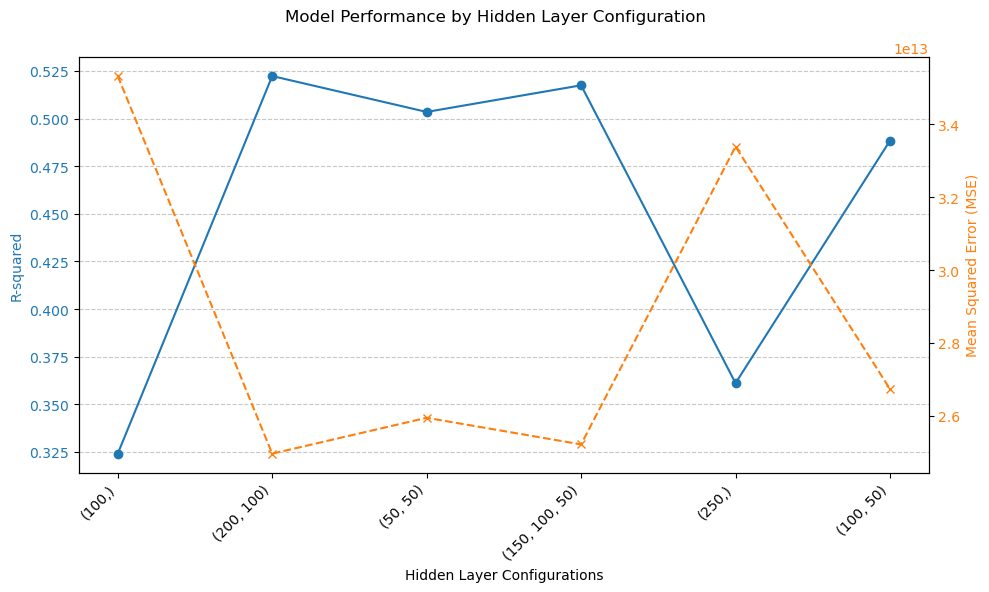

In [48]:
import matplotlib.pyplot as plt

# Prepare x-axis labels as string representations of configurations
config_labels = [str(config) for config in hidden_layer_configs]

# Plot R-squared and MSE values
fig, ax1 = plt.subplots(figsize=(10, 6))

# R-squared plot (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Hidden Layer Configurations')
ax1.set_ylabel('R-squared', color=color)
ax1.plot(config_labels, r2_scores, color=color, marker='o', label="R-squared")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(config_labels, rotation=45, ha='right')

# MSE plot (right y-axis)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Mean Squared Error (MSE)', color=color)
ax2.plot(config_labels, mse_values, color=color, marker='x', linestyle='--', label="MSE")
ax2.tick_params(axis='y', labelcolor=color)

# Add title and grid
fig.suptitle('Model Performance by Hidden Layer Configuration')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add legends
fig.tight_layout()
plt.show()
